# Causal Analysis using Bayesian Networks
## this an example of how to use the pyagrum package as sklearn compatible

In [1]:
!pip install pyagrum pydotplus

     |################################| 4.8MB 7.2MB/s eta 0:00:01011
     |################################| 286kB 26.1MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-cp36-none-any.whl size=24569 sha256=85e4cf45b04773b532b0f00dd8572cda924b30c149424aa5454e65910ff2216c
  Stored in directory: /home/wsuser/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


### This Class use the BN as a classifier and it has an internal param called BN, which is the graphical structure ...

In [2]:

from sklearn.model_selection import train_test_split
import time

import pyAgrum.lib.notebook as gnb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import numpy as np

import os
import numpy as np
import pandas as pd
import logging
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 4 decimal points

import pyAgrum as gum
#from pyAgrum.lib.bn2roc import __computeROCpoints, _computeROC
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator, ClassifierMixin

class BNEstimator(BaseEstimator, ClassifierMixin):
    """
    csv_template is used to create the modalities for the BN"""
    def __init__(self,
                 csv_template=None,
                 bn=None,
               mandatory_arcs=[],
               tabu_arcs=[],
               class_name = None,
               learning_method='greedy',
               prior='likelihood', 
               prior_weight=.5, 
               positif_label = None,
               threshold = .5,
               nb_classes = 2,               
               cut_points_percentiles  = list(100*np.linspace(0, 1,5)),
               bins=5):
        
        
        self.csv_template = csv_template
        self.mandatory_arcs = mandatory_arcs
        self.tabu_arcs = tabu_arcs
        self.class_name = class_name
        self.learning_method = learning_method
        self.prior = prior
        self.prior_weight = prior_weight
        self.positif_label = positif_label
        self.threshold = threshold
        self.nb_classes = nb_classes
        self.cut_points_percentiles = cut_points_percentiles
        self.bins = bins
        self.bn = bn
    
    
    
    def get_params(self, deep=True):
        return {"csv_template":self.csv_template,# template for modalities
            "class_name":self.class_name,
            "mandatory_arcs": self.mandatory_arcs,
                "tabu_arcs":self.tabu_arcs,
                "learning_method": self.learning_method, 
               "prior": self.prior,
               "prior_weight":  self.prior_weight,
              "class_name"  :self.class_name ,
              "positif_label"  :self.positif_label ,
              "threshold" : self.threshold ,
              "nb_classes"  :self.nb_classes ,
              "cut_points_percentiles"  :self.cut_points_percentiles,
            "bins" : self.bins}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
     
    def transform(self,d):
        """Transfrom the whole dataset before training
        param d : dataframe 
        """
        template = gum.BayesNet()
        numeric_cols = list(d.select_dtypes(include=[np.number]).columns)
        categorical_cols = list(d.select_dtypes(include=[object]).columns)

        
        for col in numeric_cols:
            if d[col].value_counts().shape[0]>self.bins:
                x = d[col].values.flatten()
                x.sort()
                cut_points = np.percentile(x, self.cut_points_percentiles)
                d.loc[:,col]= np.digitize(x, cut_points, right=False)   
                del x
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index)))) 
        for col in categorical_cols:
            if d[col].value_counts().shape[0]>self.bins:
                top = d[col].isin(d[col].value_counts().index[:self.bins])
                d.loc[~top, col] = "else_top_"+str(self.bins)

                del top
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        return template,d
        
    def fit(self,data,y=None):
        """Create the template and Fit the training dataset: data_file"""
        
        # create the template   
        
        template,_ = self.transform(pd.read_csv(self.csv_template))
        _,train= self.transform(data)
                
            
        train.to_csv('train_bn.csv',index=False)
        learner = gum.BNLearner('train_bn.csv', template)

        
        for i in self.tabu_arcs: learner.addForbiddenArc(i[0],i[1])
        for i in self.mandatory_arcs :  learner.addMandatoryArc(i[0],i[1])

        if self.learning_method == 'greedy':learner.useGreedyHillClimbing()
        else: learner.useMIIC()

        if self.prior == "laplace":learner.useAprioriSmoothing(self.prior_weight)
        else:learner.useNoApriori()
            
        

        self.bn = learner.learnBN()
        self.bn = learner.learnParameters(self.bn.dag())        
        del template,train

        return self
    def predict_one_row(self,row):
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        #markov_blanket_cols=[self.bn.variable(i).name() for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()]        
        #evs = row[markov_blanket_cols].astype(str).to_dict()
        
        evs = row.astype(str).to_dict()
        del evs[self.class_name]      
        ie.setEvidence(evs)
        ie.makeInference()
        return ie.posterior(self.class_name).toarray()
    
    def predict_proba1(self,test):
        return np.array(test.apply(self.predict_one_row,axis=1).to_list())
    
    
       
    def predict_proba1(self,test):#,mb=True):
        scores = np.empty([test.shape[0], self.nb_classes])
        scores[:] = np.nan
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        
        #markov_blanket_cols=[self.bn.variable(i).name() for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()]        
        for i in range(len(test)):    
            #ie.eraseAllEvidence()
            #if mb : evs = test[markov_blanket_cols].iloc[i,:].astype(str).to_dict()                
            #else : evs = test.iloc[i,:].astype(str).to_dict()
            evs = test.iloc[i,:].astype(str).to_dict()
            del evs[self.class_name]               
            ie.setEvidence(evs)
            ie.makeInference()
            scores[i] = ie.posterior(self.class_name).toarray()
        return scores

   
    
   
    def predict_proba(self, Xtest):
        if type(Xtest) is np.ndarray:
            Xtest = pd.DataFrame(Xtest, columns=["X{}".format(i) for i in range(Xtest.shape[1])])

        Yscores = np.empty([Xtest.shape[0], self.nb_classes])
        Yscores[:] = np.nan

        mbnames = [self.bn.variable(i).name()
                   for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()
                   if self.bn.variable(i).name() != self.class_name]
        ie = gum.LazyPropagation(self.bn)
        for var in ie.BN().names():  # ici que var de mb
            if var != self.class_name:
                ie.addEvidence(var, 0)
        ie.addTarget(self.class_name)

        Xtest = Xtest.reset_index(drop=True)

        for line in Xtest.itertuples():
            for var in mbnames:
                try:
                    idx = self.bn.variable(var).index(str(getattr(line, var)))
                    ie.chgEvidence(var, idx)
                except gum.GumException:
                # this can happend when value is missing is the test base.
                    print("[pyAgrum] ** pyAgrum.lib.classifier : The value {getattr(line, var)} for the variable {var} is missing in the training set.")
                    pass

            ie.makeInference()

            marginal = ie.posterior(self.class_name)
            Yscores[line[0]] = marginal.toarray()

        return Yscores
    def predict(self,test):
        y_scores = self.predict_proba(test)[:,1]
        y_true = test[self.class_name]
        
        return y_true, np.where(y_scores >= self.threshold, 1, 0)
    
        
 
    def score(self,test):
        from sklearn.metrics import recall_score, f1_score, classification_report
        y_true,y_pred = self.predict(test)
        print(classification_report(y_true, y_pred))
        print(5*'--')
        print('recall_score')
        return recall_score(y_true, y_pred)




In [3]:
data_url = 'https://raw.githubusercontent.com/rrichajalota/Pima-Indians-Diabetes-kaggle/master/diabetes.csv'
df = pd.read_csv(data_url)
df.to_csv('template.csv',index=False)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [4]:
import pyAgrum.lib.classifier as BNClassifier


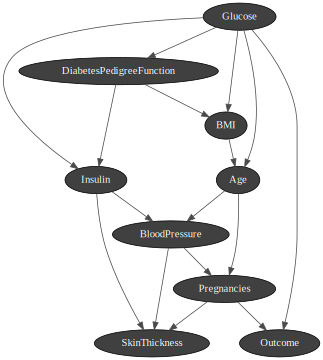

In [5]:
clf = BNEstimator(csv_template='template.csv', class_name='Outcome', mandatory_arcs=[('Glucose','Outcome'),('Pregnancies','Outcome')])
_,data = clf.transform(df)
train,test = train_test_split(data ,test_size=0.5, random_state=42)
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

clf.fit(train)
gnb.showBN(clf.bn)

In [6]:

targetColumn = 'Outcome'

x_train_df = train.drop(targetColumn, axis=1)
y_train_df = train[targetColumn]
x_test_df = test.drop(targetColumn, axis=1)
y_test_df = test[targetColumn]



In [7]:
bn = BNClassifier.BNClassifier()
bn.fit(x_train_df, y_train_df)
y_test_pred = bn.predict(x_test_df)

In [8]:
print(classification_report(
        y_true=y_test_df,
        y_pred=y_test_pred,
        output_dict=False,
    ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       254
           1       0.34      1.00      0.51       130

   micro avg       0.34      0.34      0.34       384
   macro avg       0.17      0.50      0.25       384
weighted avg       0.11      0.34      0.17       384



/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
sum(np.where((y_test_df==1) &
         (y_test_pred==0),1,0))

0

In [10]:
tn, fp, fn, tp = confusion_matrix(y_test_df, y_test_pred).ravel()
(tn, fp, fn, tp )

(0, 254, 0, 130)

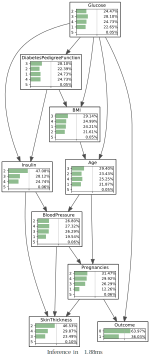

In [11]:
gnb.showInference(clf.bn)